In [1]:
from torch.utils.data import TensorDataset,DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# MY DATA


nPerCluster=100
A=[1,2]
B=[7,6]
C=[-1,-2]
a=[A[0]+np.random.randn(nPerCluster),A[1]+np.random.randn(nPerCluster)]
b=[B[0]+np.random.randn(nPerCluster),B[1]+np.random.randn(nPerCluster)]
c=[C[0]+np.random.randn(nPerCluster),C[1]+np.random.randn(nPerCluster)]

data=np.hstack((a,b,c)).T
dataT=torch.tensor(data).float()
labels=np.hstack((np.zeros(nPerCluster),np.ones(nPerCluster),1+np.ones(nPerCluster)))
labelsT=torch.tensor(labels).long()


print(labelsT.shape)
print(dataT.shape)

torch.Size([300])
torch.Size([300, 2])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


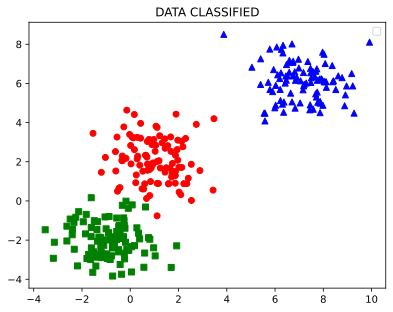

In [3]:
# VISUALIZATION
plt.title("DATA CLASSIFIED")
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'ro')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'b^')
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'gs')
plt.legend()
plt.show()

In [4]:

train_data,test_data,train_labels,test_labels=train_test_split(dataT,labelsT,train_size=.8)
train_dataset=TensorDataset(train_data,train_labels)
test_dataset=TensorDataset(test_data,test_labels)
batchNumber=16
train_loader=DataLoader(train_dataset,shuffle=True,drop_last=True,batch_size=batchNumber)
test_loader=DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0])

In [5]:
def ModelCreationWithDynamicUnits(nUnits,nLayers):
    class model(nn.Module):
        def __init__(self,nUnits,nLayers):
            super().__init__()
            self.layers=nn.ModuleDict()
            self.nLayers = nLayers

            self.layers['input']=nn.Linear(2,nUnits)
            for i in range(self.nLayers):
                self.layers[f'hidden{i}']=nn.Linear(nUnits,nUnits)
            self.layers['output']=nn.Linear(nUnits,3)
        def forward(self,x):
            x=F.relu(self.layers['input'](x))
            for i in range(self.nLayers):
                x=F.relu(self.layers[f'hidden{i}'](x))
            x=F.relu(self.layers['output'](x))
            return x
    net=model(nUnits,nLayers)
    lossFun=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(net.parameters(),lr=.1)
    return net,optimizer,lossFun

In [6]:
def function2Train():
    net,optimizer,lossFun=ModelCreationWithDynamicUnits(80,1)
    losses=[]
    ephoch_train_acc=[]
    testAcc=[]
    numEpochs=1000
    for epohchi in range(numEpochs):
        batchAcc=[]
        for X,y in train_loader:
            yHat=net(X)
            loss=lossFun(yHat,y)
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc=(torch.argmax(yHat,dim=1)==y).float()
            meanAcc=np.mean(acc.numpy())
            batchAcc.append(meanAcc)
        ephoch_train_acc.append(np.mean(batchAcc))
        X,y=next(iter(test_loader)) 
        with torch.no_grad():
            yHat=net(X)
            loss=lossFun(yHat,y)
            acc=(torch.argmax(yHat,dim=1)==y).float()
            acc=acc.numpy()
            meanAcc=np.mean(acc)
            testAcc.append(meanAcc)
    return testAcc,ephoch_train_acc,losses

total accuracy for train is 1.0
total accuracy for test is 0.9666666388511658


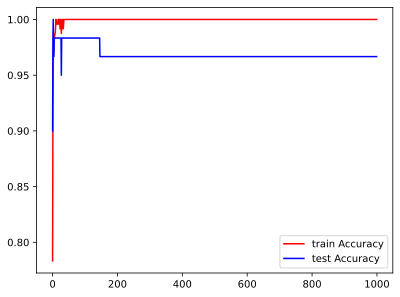

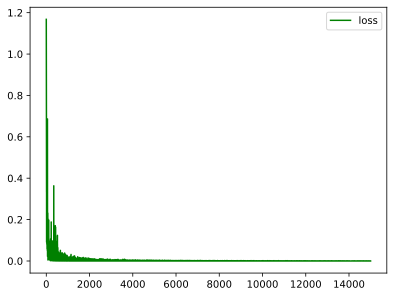

In [7]:

testAcc,ephoch_train_acc,losses=function2Train()
print(f'total accuracy for train is {ephoch_train_acc[-1]}')
print(f'total accuracy for test is {testAcc[-1]}')
#plotting the loss of train and test and accuracy of both

plt.plot(ephoch_train_acc,'r-',label="train Accuracy")
plt.plot(testAcc,'b-',label="test Accuracy")
plt.legend()
plt.show()
plt.plot(losses,'g-',label="loss")
plt.legend()
plt.show()